/home/jake/.local/lib/python2.7/site-packages/ipykernel/__main__.py:70: RuntimeWarning: invalid value encountered in divide
/home/jake/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:516: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(var_yt * var_yp)


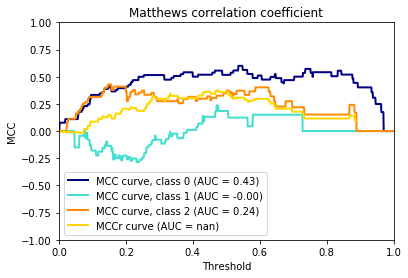

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix, matthews_corrcoef
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target

# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])
lw = 2

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

# Add noisy features
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# Split into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,
                                                    random_state=random_state)

# Run classifier
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=random_state)).fit(X_train, y_train)
#y_score = classifier.fit(X_train, y_train).decision_function(X_test)
y_score = classifier.predict_proba(X_test)
y_pred = classifier.predict(X_test)

# define multiclass MCC
def matthews_r(y_true, y_pred):
    # https://en.wikipedia.org/wiki/Matthews_correlation_coefficient#Multiclass_Case
    
    cm = confusion_matrix(y_true, y_pred)
    n_classes = cm.shape[0]
    
    sum_top = 0
    for k in range(n_classes):
        for l in range(n_classes):
            sum_top = sum_top + cm[k,k] * sum(cm[l,:]) - cm[k,l] * sum(cm[:,k])
            
    sum_left = 0
    for k in range(n_classes):
        sum_lefta = 0
        for kp in range(n_classes):
            if kp != k:
                sum_lefta = sum_lefta + sum(cm[kp,:])
        sum_left = sum_left + sum(cm[k,:]) * sum_lefta
    
    sum_right = 0
    for k in range(n_classes):
        sum_righta = 0
        for kp in range(n_classes):
            if kp != k:
                sum_righta = sum_righta + sum(cm[:,kp])
        sum_right = sum_right + sum(cm[:,k]) * sum_righta
    
    return sum_top / np.sqrt(sum_left * sum_right)


t_values = np.arange(0, 1, 1e-3)
matthews = dict()
matthews['r'] = [matthews_r(np.argmax(y_test, axis=1), np.argmax(y_score >= t, axis=1)) for t in t_values]
for i in range(n_classes):
    matthews[i] = [matthews_corrcoef(y_test[:, i], y_score[:, i] >= t) for t in t_values]

# Plot Matthews curve for each class
plt.clf()
for i, color in zip(range(n_classes), colors):
    plt.plot(t_values, matthews[i], color=color, lw=lw,
             label='MCC curve, class {0} (AUC = {1:0.2f})'
                   ''.format(i, np.trapz(matthews[i], t_values)))
plt.plot(t_values, matthews['r'], color='gold', lw=lw,
         label='MCCr curve (AUC = {0:0.2f})'
               ''.format(np.trapz(matthews['r'], t_values)))

plt.xlim([0.0, 1.0])
plt.ylim([-1.0, 1.0])
plt.xlabel('Threshold')
plt.ylabel('MCC')
plt.title('Matthews correlation coefficient')
plt.legend(loc="lower left")
plt.show()